In [1]:
! pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp38-cp38-linux_x86_64.whl size=3366451 sha256=ff8f66f47b168de6ef4e0ac56e87754373d3a0af584ea85ae2a9425e415321e0
  Stored in directory: /root/.cache/pip/wheels/af/db/86/2c18183a80ba05da35bf0fb7417aac5cddbd93bcb1b92fd3ea
Successfully built scikit-surprise


In [2]:
# Importing liberaries

import pandas as pd 
import numpy as np
from ast import literal_eval  
from nltk.stem.snowball import SnowballStemmer 
from sklearn.feature_extraction.text import CountVectorizer  
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from collections import defaultdict
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud
import seaborn as sns
import networkx as nx

import warnings  # disable python warnings
warnings.filterwarnings("ignore")

In [ ]:
# Loading datasets 

movies_data = pd.read_csv("movies_metadata.csv", low_memory=False)
credits = pd.read_csv('credits.csv')
keywords = pd.read_csv('keywords.csv')
links_small = pd.read_csv('links_small.csv')
ratings = pd.read_csv("ratings_small.csv")

In [ ]:
movies_data.describe()

,revenue,runtime,vote_average,vote_count
count,4.546000e+04,45203.000000,45460.000000,45460.000000
mean,1.120935e+07,94.128199,5.618207,109.897338
std,6.433225e+07,38.407810,1.924216,491.310374
min,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,85.000000,5.000000,3.000000
50%,0.000000e+00,95.000000,6.000000,10.000000
75%,0.000000e+00,107.000000,6.800000,34.000000
max,2.787965e+09,1256.000000,10.000000,14075.000000


In [ ]:
# Checking for null values in the dataset

print(movies_data.isnull().sum(),'\n') 
print(links_small.isnull().sum(),'\n')
print(ratings.isnull().sum(),'\n')
print(keywords.isnull().sum(),'\n')
print(credits.isnull().sum(),'\n')


adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64 

movieId     0
imdbId      0
tmdbId     13
dtype: int64 

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64 

id          0
keywords    0
dtype: int64 

cast    0
crew    0
id      0
dtype: int64 



In [ ]:
# Removing the rows with null value in the vote_average and vote_count columns in movies_data dataframe

movies_data = movies_data.dropna(subset=['vote_average', 'vote_count'])
print(movies_data.isnull().sum(),'\n')

adult                        0
belongs_to_collection    40970
budget                       0
genres                       0
homepage                 37682
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   0
poster_path                383
production_companies         0
production_countries         0
release_date                84
revenue                      0
runtime                    257
spoken_languages             0
status                      81
tagline                  25048
title                        0
video                        0
vote_average                 0
vote_count                   0
dtype: int64 



## SIMPLE RECOMMENDER SYSTEM



In [ ]:
# Simple Recommender (Top movies irrespective of genres)

# Weighted rating
def weighted_rating(v,R):
    return ((v/(v+m)) * R) + ((m/(m+v)) * C)  
    # IMDB calculation matrix for rating movies
    # v (int): vote count
    # R (int): vote average
    

C = movies_data['vote_average'].mean()         # mean vote across all data
m = movies_data['vote_count'].quantile(0.95)   # movies with more than 95% votes is taken (95 percentile)

# Taking movies whose vote count is greater than m
top_movies = movies_data.copy().loc[movies_data['vote_count'] >= m]
top_movies = top_movies.reset_index()

top_movies['score'] = ''

for i in range(top_movies.shape[0]):
    v = top_movies['vote_count'][i]          # number of vote count of the movie
    R = top_movies['vote_average'][i]        # average rating of the movie
    top_movies['score'][i] = weighted_rating(v,R)

top_movies = top_movies.sort_values('score', ascending=False)  # sorting movies in descending order according to score
top_movies = top_movies.reset_index()

t1 = top_movies[['title', 'score']].head(20)

print(t1)

                                            title     score
0                        The Shawshank Redemption  8.357746
1                                   The Godfather  8.306334
2                                 The Dark Knight  8.208376
3                                      Fight Club  8.184899
4                                    Pulp Fiction  8.172155
5                                    Forrest Gump  8.069421
6                                Schindler's List  8.061007
7                                        Whiplash  8.058025
8                                   Spirited Away  8.035598
9                         The Empire Strikes Back  8.025793
10                                      Inception  8.025763
11                              Life Is Beautiful  8.014521
12                               The Intouchables  8.008265
13                                   Interstellar  8.007315
14                         The Godfather: Part II  7.997846
15  The Lord of the Rings: The Return of

In [ ]:
# Distribution of average vote among movies in the dataset

fig = px.histogram(top_movies, x="vote_average")
fig.show()

### Simple recommender system (based on genres)

In [ ]:
top_movies

,level_0,index,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,score
0,46,314,False,NaN,25000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",NaN,278,tt0111161,en,...,2.834147e+07,142.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Fear can hold you prisoner. Hope can set you f...,The Shawshank Redemption,False,8.5,8358.0,8.357746
1,111,834,False,"{'id': 230, 'name': 'The Godfather Collection'...",6000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",http://www.thegodfather.com/,238,tt0068646,en,...,2.450664e+08,175.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,An offer you can't refuse.,The Godfather,False,8.5,6024.0,8.306334
2,1135,12481,False,"{'id': 263, 'name': 'The Dark Knight Collectio...",185000000,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",http://thedarkknight.warnerbros.com/dvdsite/,155,tt0468569,en,...,1.004558e+09,152.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Why So Serious?,The Dark Knight,False,8.3,12269.0,8.208376
3,439,2843,False,NaN,63000000,"[{'id': 18, 'name': 'Drama'}]",http://www.foxmovies.com/movies/fight-club,550,tt0137523,en,...,1.008538e+08,139.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Mischief. Mayhem. Soap.,Fight Club,False,8.3,9678.0,8.184899
4,43,292,False,NaN,8000000,"[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n...",NaN,680,tt0110912,en,...,2.139288e+08,154.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Just because you are a character doesn't mean ...,Pulp Fiction,False,8.3,8670.0,8.172155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2269,1725,21238,False,"{'id': 286023, 'name': 'Sharknado Collection',...",1000000,"[{'id': 10770, 'name': 'TV Movie'}, {'id': 27,...",http://www.theasylum.cc/product.php?id=230,205321,tt2724064,en,...,0.000000e+00,86.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Enough said!,Sharknado,False,3.8,484.0,4.659588
2270,1961,26563,False,NaN,120000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.fantasticfourmovie.com/,166424,tt1502712,en,...,1.679776e+08,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Change is coming.,Fantastic Four,False,4.4,2322.0,4.591837
2271,1981,28207,False,NaN,4000000,"[{'id': 53, 'name': 'Thriller'}]",http://www.theboynextdoorfilm.com/,241251,tt3181822,en,...,5.242586e+07,91.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Moment She Couldn't Resist. An Obsession He ...,The Boy Next Door,False,4.1,1034.0,4.548843
2272,246,1491,False,"{'id': 120794, 'name': 'Batman Collection', 'p...",125000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,415,tt0118688,en,...,2.382071e+08,125.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Strength. Courage. Honor. And loyalty.,Batman & Robin,False,4.2,1447.0,4.527221


In [ ]:
# Simple recommender based on genres

genres = set()

# Finding the exhaustive set of genres in the dataset 
top_movies['genres'] = top_movies['genres'].apply(literal_eval)
for i in range(top_movies['genres'].shape[0]):   # converting string in map
    for x in top_movies['genres'][i]:
        genres.add(x['name'])
        
        
# creating map of string (genre name) and movies names(dataframe)
genres_based = dict()   
for i in range(top_movies['genres'].shape[0]):  
    for x in top_movies['genres'][i]:
        if x['name'] not in genres_based.keys():
            genres_based[x['name']] = pd.DataFrame(columns = top_movies.columns)
        genres_based[x['name']] = genres_based[x['name']].append(top_movies.iloc[i])  

In [ ]:
genres_based['Drama']

,level_0,index,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,score
0,46,314,False,NaN,25000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",NaN,278,tt0111161,en,...,2.834147e+07,142.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Fear can hold you prisoner. Hope can set you f...,The Shawshank Redemption,False,8.5,8358.0,8.357746
1,111,834,False,"{'id': 230, 'name': 'The Godfather Collection'...",6000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",http://www.thegodfather.com/,238,tt0068646,en,...,2.450664e+08,175.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,An offer you can't refuse.,The Godfather,False,8.5,6024.0,8.306334
2,1135,12481,False,"{'id': 263, 'name': 'The Dark Knight Collectio...",185000000,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",http://thedarkknight.warnerbros.com/dvdsite/,155,tt0468569,en,...,1.004558e+09,152.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Why So Serious?,The Dark Knight,False,8.3,12269.0,8.208376
3,439,2843,False,NaN,63000000,"[{'id': 18, 'name': 'Drama'}]",http://www.foxmovies.com/movies/fight-club,550,tt0137523,en,...,1.008538e+08,139.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Mischief. Mayhem. Soap.,Fight Club,False,8.3,9678.0,8.184899
5,52,351,False,NaN,55000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,13,tt0109830,en,...,6.779454e+08,142.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"The world will never be the same, once you've ...",Forrest Gump,False,8.2,8147.0,8.069421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2233,1770,21848,False,NaN,25000000,"[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n...",NaN,109091,tt2193215,en,...,7.100933e+07,117.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Sin Is A Choice.,The Counselor,False,5.0,724.0,5.231694
2237,985,11012,False,NaN,0,"[{'id': 14, 'name': 'Fantasy'}, {'id': 18, 'na...",NaN,4474,tt0465624,en,...,6.089615e+07,95.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Hell hath no fury like a superwoman scorned.,My Super Ex-Girlfriend,False,4.8,453.0,5.200340
2246,2081,32891,False,NaN,2500000,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",http://knockknockmovie.tumblr.com/,263472,tt3605418,en,...,6.341684e+06,99.0,"[{'iso_639_1': 'es', 'name': 'Español'}, {'iso...",Released,One night can cost you everything.,Knock Knock,False,4.9,880.0,5.137216
2249,1682,20598,False,NaN,5000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",http://www.springbreakersmovie.com/,122081,tt2101441,en,...,3.172428e+07,94.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A little sun can bring out your dark side.,Spring Breakers,False,5.0,1580.0,5.133218


In [ ]:
# Visualizing frequency of occurence of different genres

# Creating a count vector (list) containing frequency of a perticular genre
cnt = list()
for i in genres:
    cnt.append(genres_based[i].shape[0])
    
# Making a datafram 
genre_cnt = pd.DataFrame( { 'genres' : list(genres),
                            'count'  : cnt
    
},
                         columns = ['genres','count']
)

fig = px.bar(genre_cnt, x='genres', y='count')
fig.show()

In [ ]:
# This function returns the top 10 movies of the given genre
def genres_based_rcmnd(name):
    if name not in genres:
        return None
    else:
        return genres_based[name][['title', 'vote_count', 'vote_average', 'score']].head(10)


print(genres_based_rcmnd("Comedy"))

                          title  vote_count  vote_average     score
5                  Forrest Gump      8147.0           8.2  8.069421
11            Life Is Beautiful      3643.0           8.3  8.014521
12             The Intouchables      5410.0           8.2  8.008265
30           Back to the Future      6239.0           8.0  7.845092
35     The Grand Budapest Hotel      4644.0           8.0  7.796436
41      The Wolf of Wall Street      6768.0           7.9  7.762497
42                   Inside Out      6737.0           7.9  7.761902
52  Dilwale Dulhania Le Jayenge       661.0           9.1  7.720002
57                   La La Land      4745.0           7.9  7.708786
62                           Up      7048.0           7.8  7.673443


## CONTENT BASED RECOMMENDER SYSTEM 

In [ ]:
Preprocessing the data

movies_data['id'] = movies_data['id'].astype('int') 

# merging both credits and keywords in movies_data on the basis of movie id
movies_data = movies_data.merge(credits, on='id')
movies_data = movies_data.merge(keywords, on='id')

links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

# taking only those movies whos id is present in link_small because of limited computing power
smd = movies_data[movies_data['id'].isin(links_small)]  
smd = smd.reset_index()

smd.head()

,index,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords
0,0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [ ]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan


# Applying literal_eval to get the right data type from the expression of string
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['genres'] = smd['genres'].apply(literal_eval)

smd['director'] = smd['crew'].apply(get_director) 

# Taking all the movie cast in a list and then taking only the top 3 cast
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])# Strip Spaces and Convert to Lowercase

smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

smd['genres'] = smd['genres'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['genres'] = smd['genres'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x,x])  # giving more weight to the director relative to the entire cast

In [ ]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in keywords_count.keys():
            words.append(i)
    return words


# Creating the count of every keywords
keywords_count = dict()
for i in range(len(smd['keywords'])):
    for j in range(len(smd['keywords'][i])):
        if smd['keywords'][i][j] not in keywords_count.keys():
            keywords_count[smd['keywords'][i][j]] = 0
        keywords_count[smd['keywords'][i][j]] +=1

# removing those keywords which occur only once
for i in list(keywords_count):
    if keywords_count[i] == 1:
        del keywords_count[i]

In [ ]:
# preprocessing

# Stemming the words 
stemmer = SnowballStemmer('english')

smd['keywords'] = smd['keywords'].apply(filter_keywords) # removing those keywords which occur only once
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

# combining keywords, cast, director and genres
smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))
smd['soup'][0] 

'jealousi toy boy friendship friend rivalri boynextdoor newtoy toycomestolif tomhanks timallen donrickles johnlasseter johnlasseter johnlasseter animation comedy family'

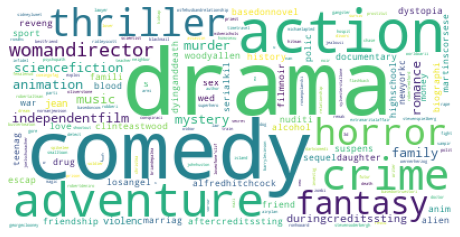

In [ ]:
# Creating the Wordcloud for visualisation of the word which occur frequently in the dataset

# Combining all the text contained in smd['soup'] column
text = ""
for i in smd['soup']:
    text +=i
    
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

# Display the generated Word Cloud
# plot the WordCloud image                      
plt.figure(figsize = (8, 8))
plt.imshow(word_cloud)
plt.axis("off")
 
plt.show()

In [ ]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2) ,min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

cosine_sim = cosine_similarity(count_matrix, count_matrix)

titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])  # Creating a mapping between movie and title and index

In [ ]:
df_cosine=pd.DataFrame(cosine_sim)
df_cosine

,0,1,2,3,4,5,6,7,8,9,...,9209,9210,9211,9212,9213,9214,9215,9216,9217,9218
0,1.000000,0.024419,0.027390,0.025777,0.024419,0.000000,0.026547,0.029348,0.000000,0.000000,...,0.000000,0.000000,0.023816,0.000000,0.020947,0.030500,0.000000,0.000000,0.000000,0.0
1,0.024419,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.061633,0.027067,0.021592,...,0.000000,0.000000,0.050016,0.000000,0.000000,0.000000,0.000000,0.029735,0.025641,0.0
2,0.027390,0.000000,1.000000,0.060718,0.028760,0.000000,0.062531,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.024671,0.000000,0.034565,0.033352,0.000000,0.0
3,0.025777,0.000000,0.060718,1.000000,0.027067,0.019263,0.058849,0.032530,0.000000,0.000000,...,0.000000,0.023669,0.026398,0.033806,0.023218,0.033806,0.032530,0.062776,0.027067,0.0
4,0.024419,0.000000,0.028760,0.027067,1.000000,0.000000,0.027875,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.021995,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9214,0.030500,0.000000,0.000000,0.033806,0.000000,0.022792,0.000000,0.038490,0.000000,0.000000,...,0.000000,0.028006,0.031235,0.040000,0.000000,1.000000,0.000000,0.037139,0.032026,0.0
9215,0.000000,0.000000,0.034565,0.032530,0.000000,0.021932,0.033501,0.000000,0.032530,0.025950,...,0.000000,0.026948,0.000000,0.038490,0.000000,0.000000,1.000000,0.071474,0.000000,0.0
9216,0.000000,0.029735,0.033352,0.062776,0.000000,0.021162,0.032325,0.107211,0.031388,0.025039,...,0.000000,0.026003,0.087002,0.037139,0.000000,0.037139,0.071474,1.000000,0.089205,0.0
9217,0.000000,0.025641,0.000000,0.027067,0.000000,0.036497,0.000000,0.154083,0.081200,0.043183,...,0.000000,0.022422,0.125039,0.032026,0.065986,0.032026,0.000000,0.089205,1.000000,0.0


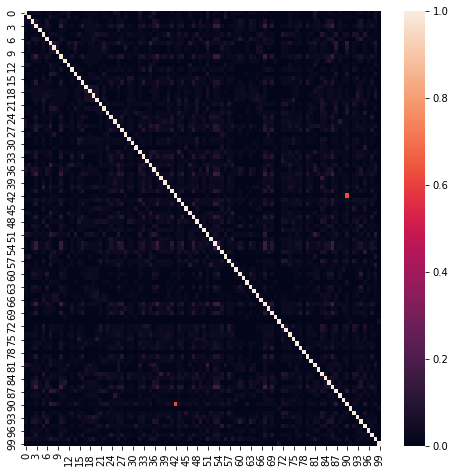

In [ ]:
# Creating Heatmap for visualization of correlation between different movies 

#specify size of heatmap
fig, ax = plt.subplots(figsize=(8, 8))

#create seaborn heatmap of only top 100 movies
sns.heatmap(cosine_sim[:100,:100])

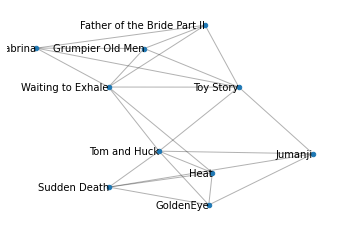

In [ ]:
# Graph structure to visualize similarity relation between selected movies

g = nx.Graph()
n = 10

for i in range(n):
    g.add_node(titles[i])

for i in range(n):
    for j in range(n):
        if i != j and cosine_sim[i][j]>0:
            g.add_edge(titles[i],titles[j],weight = cosine_sim[i][j])
    
g = g.to_undirected()
pos = nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, node_size = 20)
nx.draw_networkx_edges(g, pos,alpha = 0.3)
nx.draw_networkx_labels(g, pos, font_size=10, horizontalalignment="right")

plt.axis("off")
plt.show()

In [ ]:
indices

title
Toy Story                                                0
Jumanji                                                  1
Grumpier Old Men                                         2
Waiting to Exhale                                        3
Father of the Bride Part II                              4
                                                      ... 
The Last Brickmaker in America                        9214
Rustom                                                9215
Mohenjo Daro                                          9216
Shin Godzilla                                         9217
The Beatles: Eight Days a Week - The Touring Years    9218
Length: 9219, dtype: int64

In [ ]:
def get_recommendations(title):
    idx = indices[title] # movie id corrosponding to the given title 
    sim_scores = list(enumerate(cosine_sim[idx])) # list of cosine similarity scores value along the given index
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True) # sorting the given scores in ascending order
    sim_scores = sim_scores[1:31] # Taking only the top 30 scores
    movie_indices = [i[0] for i in sim_scores] # Finding the indices of 30 most similar movies
    return titles.iloc[movie_indices] 

get_recommendations('The Dark Knight').head(10)

8031         The Dark Knight Rises
6218                 Batman Begins
6623                  The Prestige
2085                     Following
7648                     Inception
4145                      Insomnia
3381                       Memento
8613                  Interstellar
7659    Batman: Under the Red Hood
1134                Batman Returns
Name: title, dtype: object

## Collaborative filtering


In [ ]:
# drop the timestamp column since we dont need it now
ratings = ratings.drop(columns="timestamp")

#checking for missing values
ratings.isna().sum()

#check for the numbers of total movies and users
movies= ratings['movieId'].nunique()  #nunique is similar to count but only takes unique values
users=ratings['userId'].nunique()
print('total number of movies =', movies)
print('total number of users =', users)

#  HIstogram showing frequency of ratings given by different users
fig = px.histogram(ratings, x="rating")
fig.show()

total number of movies = 9066
total number of users = 671


In [ ]:
# columns to use for training
columns = ['userId','movieId','rating']

# create reader from surprise 
# the rating should lie in the provided scale
reader = Reader(rating_scale =(0.5,5))

#create dataset from dataframe
data = Dataset.load_from_df(ratings[columns],reader)

# create trainset ie the data which is present (ratings of those movies which are rated by respective users)
trainset = data.build_full_trainset()

# create testset, here the anti_testset is testset
# data containing users movie pairs which are not rated by that particular user
testset = trainset.build_anti_testset()
 

model = SVD(n_epochs = 25, verbose = True) #n_epochs:The number of iteration of the SGD(simple gradient descent) procedure. Default is 20
                                           #verbose:If True, prints the current epoch. Default is False.
    
cross_validate(model, data, measures=['RMSE','MAE'], cv= 5, verbose= True)
print('Training Done')

#prediction
prediction = model.test(testset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
P

### Using user rating of selected movies to get suitable recommendations

1. To incorporate the user in the system we inspected the dataset and found that mostly users have around 5-10 ratings.
2. To get recommendation according to taste of user we prompt the user to rate the selected movies.
3. We add those selection to our standerd dataset and run the collaborative filtering algorithm to get the ratings of other movies.
4. Finally, recommending top 10 movies based on highest ratings.

In [ ]:
example = { 'userId' : [99999,99999,99999,99999,99999],
           'movieId' : [31,1029,1293,1172,1343],
           'rating'  : [3.0, 4.5, 1.2, 3.3,2]
    
}

df = pd.DataFrame(example)
frames = [ratings, df]
result = pd.concat(frames)

In [ ]:
#create dataset from dataframe
data= Dataset.load_from_df(result[columns],reader)

#create trainset
trainset= data.build_full_trainset()

#create testset, here the anti_testset is testset
testset = trainset.build_anti_testset()

cross_validate(model,data, measures=['RMSE','MAE'], cv= 5, verbose= True) #cv is the number of parts in which data will be divided.
print('Training Done')

#prediction
prediction = model.test(testset)
prediction[99999]

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
P

Prediction(uid=12, iid=4344, r_ui=3.5435710786029255, est=2.333551925170688, details={'was_impossible': False})

In [ ]:
# This function recommend users with top n movies based on prediction calculated using the surprise library
def get_top_n(prediction, n):
  
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in prediction: 
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the n highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

rcmnd = []
top_n = get_top_n(prediction, n=30)
for uid, user_ratings in top_n.items():
    if uid == 99999:
        for (iid,rating) in user_ratings:
            for i in range(movies_data.shape[0]):
                if movies_data['id'][i] == iid:
                    rcmnd.append([movies_data['id'][i],movies_data['title'][i]])
        break

In [ ]:
rcmnd[:10]

[[745, 'The Sixth Sense'],
 [913, 'The Thomas Crown Affair'],
 [318, 'The Million Dollar Hotel'],
 [1252, 'Lonely Hearts'],
 [951, 'Kindergarten Cop'],
 [2692, 'The Red Elvis'],
 [912, 'The Thomas Crown Affair'],
 [222, 'Berlin: Symphony of a Great City'],
 [111, 'Scarface'],
 [916, 'Bullitt']]

## Tkinter


In [ ]:
import tkinter as tk
import tkinter.ttk
from tkinter import *
import tkinter.messagebox

In [ ]:
# Callback function used for the submit button on the interface
# This function takes input directly from the Tkinter interface and based on the type of input provided it finds recommendation for the user and provide output on the Tkinter interface.

l = [None for i in range(10)]

def genre_based():
 

    for i in range(10):
        if l[i] is not None:
            l[i].grid_remove()
    event = clicked.get()

    # produced recommendations for the user based on the rating provided to selected movies if no genre is selected else recommend top movies from the selected genres
    if event == "Select Genre":
        rtts = list()
        rtts.append(l11.get())
        rtts.append(l12.get())
        rtts.append(l13.get())
        rtts.append(l14.get())
        rtts.append(l15.get())
        movie_ratings = [int(i) for i in rtts]
        print(movie_ratings)
        
        example = { 'userId' : [99999,99999,99999,99999,99999],
           'movieId' : [278, 13,637,122, 11],
           'rating'  : movie_ratings,
                  }
        
        df = pd.DataFrame(example)
        frames = [ratings, df]
        result = pd.concat(frames)
        
        #create dataset from dataframe
        data= Dataset.load_from_df(result[columns],reader)

        #create trainset
        trainset= data.build_full_trainset()

        #create testset, here the anti_testset is testset
        testset = trainset.build_anti_testset()

        cross_validate(model,data, measures=['RMSE','MAE'], cv= 5, verbose= True)
        print('Training Done')

        #prediction
        prediction = model.test(testset)
        prediction[99999]

        # An RMSE value of less than 2 is considered good
        #Now Recommend Users top 10 movies based on prediction

        from collections import defaultdict
        def get_top_n(prediction, n):

            # First map the predictions to each user.
            top_n = defaultdict(list)
            for uid, iid, true_r, est, _ in prediction:
                top_n[uid].append((iid, est))

            # Then sort the predictions for each user and retrieve the n highest ones.
            for uid, user_ratings in top_n.items():
                user_ratings.sort(key=lambda x: x[1], reverse=True)
                top_n[uid] = user_ratings[:n]

            return top_n

        rcmnd = []
        top_n = get_top_n(prediction, n=30)
        for uid, user_ratings in top_n.items():
            if uid == 99999:
                for (iid,rating) in user_ratings:
                    for i in range(movies_data.shape[0]):
                        if movies_data['id'][i] == iid:
                            rcmnd.append([movies_data['id'][i],movies_data['title'][i]])
                break
    
        for i in range(min(10,len(rcmnd))):
            l[i] = Label(root ,  text = rcmnd[i][1])
            l[i].grid(row = 2+i, column = 5, sticky = W, pady = 5)                
    else:
        ll = list((genres_based[event][['title']].head(10))['title'])
        for i in range(min(10,len(ll))):
            l[i] = Label(root ,  text = ll[i])
            l[i].grid(row = 2+i, column = 5, sticky = W, pady = 5)

In [ ]:
# temp dataframe contains movies which are present in both ratings and movies_data dataframe

id_list = list(ratings['movieId'])
temp = movies_data.loc[movies_data['id'].isin(id_list)]
temp = temp.reset_index()
print(temp[['id' , 'title']])
temp['title'][1]

         id                       title
0       949                        Heat
1       710                   GoldenEye
2      1408            Cutthroat Island
3       524                      Casino
4      4584       Sense and Sensibility
...     ...                         ...
2843  80831                Sang Pemimpi
2844   3104  Frankenstein Created Woman
2845  64197        Travelling with Pets
2846  98604                  Cinderella
2847  49280            The One-Man Band

[2848 rows x 2 columns]


'GoldenEye'

In [ ]:
# This snippet is used to find top ranked movies according to imdb score which are present in temp dataframe.

available_movies = []

for movie in list(t1['title']):
    movie = movie.lower()
    for i in range(temp.shape[0]):
        name = temp['title'][i].lower()
        if name == movie:
            available_movies.append((temp['id'][i] , movie))
            
print(available_movies)

[(278, 'the shawshank redemption'), (238, 'the godfather'), (155, 'the dark knight'), (550, 'fight club'), (680, 'pulp fiction'), (13, 'forrest gump'), (424, "schindler's list"), (129, 'spirited away'), (1891, 'the empire strikes back'), (637, 'life is beautiful'), (240, 'the godfather: part ii'), (122, 'the lord of the rings: the return of the king'), (101, 'leon: the professional'), (510, "one flew over the cuckoo's nest"), (497, 'the green mile'), (11, 'star wars')]


In [ ]:
# create root window
root = Tk()

# root window title and dimension4
root.title("AZ Movie Recommender System")

# Set geometry (widthxheight)
root.geometry('1000x400')

''

In [ ]:
# Dropdown menu options
options = [
    'Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'TV Movie',
 'Thriller',
 'War',
 'Western'
]

# adding a label to the root window
l1 = Label(root, text = "MOVIE RECOMMENDER SYSTEM", fg = "blue")
l1.grid(row = 0,column = 1)
l2 = Label(root, text = "Select genre of the movie you want to watch : ")
l2.grid(row = 1,column = 0,sticky = W, pady = 2)

# datatype of menu text
clicked = StringVar()

# initial menu text
clicked.set( "Select Genre" )

# Create Dropdown menu
drop = OptionMenu( root , clicked , *options)
drop.grid(row = 3,column = 0, sticky = W)

# Creating seperators for better UI 
x1 = tkinter.ttk.Separator(root, orient=VERTICAL).grid(column=1, row=1, rowspan=12, sticky='ns')

l3 = Label(root, text = "Rate the following movies")
l3.grid(row = 1,column = 2,sticky = W, pady = 2)

# labels for movies name
l4 = Label(root, text="Movies Name").grid(row=2, column=2)
l5 = Label(root, text="the shawshank redemption").grid(row=3, column=2) # 278
l6 = Label(root, text="forest gump").grid(row=4, column=2) # 13
l7 = Label(root, text="life is beautiful").grid(row=5, column=2) #637
l8 = Label(root, text="the lord of the rings: the return of the king").grid(row=6, column=2) #122
l9 = Label(root, text="star wars").grid(row=7, column=2) # 11

# label for movies rating
l10 = Label(root, text="Rate the movie on the scale of 5").grid(row=2, column=3)
l11 = Spinbox(root, from_= 0, to = 5)
l11.grid(row=3, column=3)
l12 = Spinbox(root, from_= 0, to = 5)
l12.grid(row=4, column=3)
l13= Spinbox(root, from_= 0, to = 5)
l13.grid(row=5, column=3)
l14 = Spinbox(root, from_= 0, to = 5)
l14.grid(row=6, column=3)
l15 = Spinbox(root, from_= 0, to = 5)
l15.grid(row=7, column=3)


# button widget with green color text
button = Button(root, text = "SUBMIT" , fg = "white",bg = "green", command = genre_based)
button.grid(row = 9,column = 1, sticky = S)

# Creating seperators for better UI 
x2 = tkinter.ttk.Separator(root, orient=VERTICAL).grid(column=4, row=1, rowspan=12, sticky='ns')

l16 = Label(root, text="Results").grid(row=1, column= 5, sticky = W, pady=10)

In [ ]:
# start the program
root.mainloop()

[1, 2, 1, 4, 5]
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Proc